In [1]:
import os
import argparse
import matplotlib
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.nn import functional as F
from tqdm import tqdm
from skimage.segmentation import mark_boundaries
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from skimage import morphology, measure
from scipy.ndimage import gaussian_filter
from models.unet import UNet
from utils.gen_mask import gen_mask
from losses.gms_loss import MSGMS_Score
from losses.hsv_loss import HSV_Score
from dataset.mvtec import MVTecDataset
from utils.funcs import denormalization

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#plt.switch_backend('agg')


In [2]:
obj = 'eur50_real_back'
data_type = 'mvtec'
data_path = 'examining/mvtec'
checkpoint_dir = './results/models/eur50_real_back/seed_4420/eur50_real_back_2023-12-13-4233_model.pt'
grayscale = False
batch_size = 16
img_size = 256
seed = 4420
ratio = 95
k_value = [4, 8, 16, 32]

save_dir = 'examining/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# load model and dataset
input_channel = 1 if grayscale else 3
model = UNet().to(device)
checkpoint = torch.load(checkpoint_dir)
model.load_state_dict(checkpoint['model'])

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

test_dataset = MVTecDataset(data_path, class_name=obj, is_train=False, resize=img_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, **kwargs)



In [3]:
def test(k_value, model, test_loader):
    model.eval()
    
    scores = []
    test_imgs = []
    gt_list = []
    gt_mask_list = []
    recon_imgs = []
    msgms_score = MSGMS_Score()

    for (data, label, mask) in tqdm(test_loader):

        #print('---> test data shape : ', data.shape)

        test_imgs.extend(data.cpu().numpy())
        gt_list.extend(label.cpu().numpy())
        gt_mask_list.extend(mask.cpu().numpy())
        score = 0
        
        with torch.no_grad():
            data = data.to(device)
            for k in k_value:
                img_size : int = data.size(-1)


                N = img_size // k
                Ms_generator  = gen_mask([k], 3, img_size)  # <class 'generator'>


                Masks = next(Ms_generator)

                #list_info('Ms',Masks)

                inputs = [data * (torch.tensor(mask, requires_grad=False).to(device)) for mask in Masks]
                #plot_list_of_tensors(inputs)
                outputs = [model(x) for x in inputs]


                #list_info('inputs',inputs)
                #list_info('outputs',outputs)
                
                masked_outputs = [x * (torch.tensor(1 - y, requires_grad=False).to(device)) for x, y in zip(outputs, Masks)]
                #


                output = sum(masked_outputs)
                #output = sum(map(lambda x, y: x * (torch.tensor(1 - y, requires_grad=False).to(device)), outputs, Masks))
                
                #plot_tensor(output)
                #list_info('outputs',outputs)

                #print('output->', output.cpu().numpy()[0].shape)
                heat_map = msgms_score(data, output)
                heat_map = np.asarray(heat_map[0][0].cpu().numpy())
                heat_map = heat_map / (N**2)
                
                #plt.imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none')
                #plt.show()

                score += msgms_score(data, output) / (N**2)

        score = score.squeeze().cpu().numpy()
        for i in range(score.shape[0]):
            score[i] = gaussian_filter(score[i], sigma=7)
        scores.extend(score)
        recon_imgs.extend(output.cpu().numpy())
    return scores, test_imgs, recon_imgs, gt_list, gt_mask_list




In [ ]:
scores, test_imgs, recon_imgs, gt_list, gt_mask_list = test(k_value, model, test_loader)

In [37]:
def plot_list_of_tensors(list):
    n = len(list)
    
    for tensor in list:
        plt.figure(figsize=(10, 10))
        plt.imshow(tensor)
        plt.axis('off')
        plt.show()



In [108]:
def plot_tensor_grid(tensor_list1, tensor_list2):

    n = len(tensor_list1)

    for i in range(2):
        fig, axs = plt.subplots(2, n)
        fig.figuresize = (20, 5)

        for j in range(n):

            img = tensor_list1[j][i].cpu().numpy()
            img = denormalization(img)
            axs[0, j].imshow(img)
            axs[0, j].axis("off")

            img = tensor_list2[j][i].cpu().numpy()
            img = denormalization(img)
            axs[1, j].imshow(img)
            axs[1, j].axis("off")

    fig.show()

In [68]:
def plot_tensor(tensor):
    n = tensor.shape[0]
    plt.figure(figsize=(10, 5))
    for i in range(n):
        
        plt.subplot(1, n, i+1)
        img  = tensor[i].cpu().numpy()
        img = denormalization(img)
        plt.imshow(img)
        plt.axis('off')

In [61]:
def list_info(name, list):
    print('---------------- ', name)
    print(type(list))
    print('Length:', len(list))
    for i in list:
        print(type(i))
        print(i.shape)
    print('----------------')
    

In [ ]:
scores, test_imgs, recon_imgs, gt_list, gt_mask_list = test(k_value, model, test_loader)

In [26]:
#scores, test_imgs, recon_imgs, gt_list, gt_mask_list
print('scores : ', scores[0].shape)
print('test_imgs : ', test_imgs[0].shape)
print('recon_imgs : ', recon_imgs[0].shape)
print('gt_list : ', gt_list)
print('gt_mask_list : ', gt_mask_list[0].shape)

print('scores : ', len(scores))
print('test_imgs : ', type(test_imgs[0]))
print('recon_imgs : ', type(recon_imgs[0]))
print('gt_list : ', type(gt_list[0]))
print('gt_mask_list : ', type(gt_mask_list[0]))


scores :  (256, 256)
test_imgs :  (3, 256, 256)
recon_imgs :  (3, 256, 256)
gt_list :  [1, 0]
gt_mask_list :  (1, 256, 256)
scores :  2
test_imgs :  <class 'numpy.ndarray'>
recon_imgs :  <class 'numpy.ndarray'>
gt_list :  <class 'numpy.int64'>
gt_mask_list :  <class 'numpy.ndarray'>


In [26]:
weight_map = np.load('./results/models/eur50_real_front/seed_3514/weight_map_H.npy')
weight_map2 = np.load('./results/models/eur50_real_front/seed_3514/weight_map_S.npy')
weight_map3 = np.load('./results/models/eur50_real_front/seed_3514/weight_map_V.npy')

In [27]:
#weight_map = np.load('./results/models/eur50_real_back/seed_4420/weight_map_H.npy')
#weight_map2 = np.load('./results/models/eur50_real_back/seed_4420/weight_map_S.npy')
#weight_map3 = np.load('./results/models/eur50_real_back/seed_4420/weight_map_V.npy')


#weight_map[:, -40:-15] = 0.01
#weight_map2[:, -40:-15] = 0.01
#weight_map3[:, -40:-15] = 0.01

bin_weight = cv2.imread('./results/models/eur50_real_back/seed_4420/binary_weight.png')
bin_weight = np.asarray(bin_weight[:, :, 0])
bin_weight = bin_weight / np.max(bin_weight) # normalization
#np.save('./results/models/eur50_real_back/seed_4420/binary_weight_HSV.npy', bin_weight)


exp_weight = 5
#weight_map = (weight_map)**exp_weight
weight_map2 = (weight_map2)**exp_weight
weight_map3 = (weight_map3)**exp_weight

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(weight_map)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(weight_map2)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.imshow(weight_map3)
plt.colorbar()
plt.savefig('PLOT3.png')

In [140]:
img = cv2.imread('examining/reconstructions/real_front/00043.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

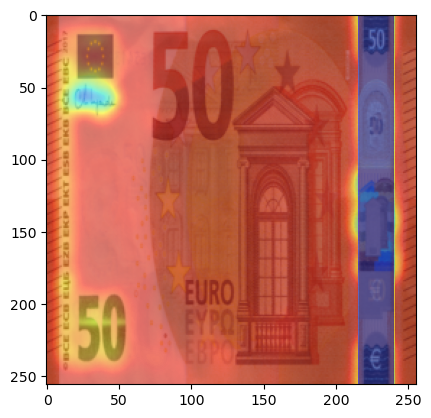

In [172]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.imshow(weight_map*255, cmap='jet', alpha=0.5)

In [ ]:
import matplotlib.gridspec as gridspec

def visualize_HSV_difference(image1, image2, hsv_channel = 0):
    # Convert images to the HSV color space
    hsv_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2HSV)
    hsv_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2HSV)

    if hsv_channel == 0: norm_value = 180.0
    else: norm_value = 255.0

    # Extract HSV channels and normalize
    hsv_channel1 = hsv_image1[:, :, hsv_channel].astype(float) / norm_value
    hsv_channel2 = hsv_image2[:, :, hsv_channel].astype(float) / norm_value

    # Compute the absolute pixel-wise difference in the HUE channel
    hue_difference = np.abs(hsv_channel1 - hsv_channel2)
    
    # Plot the difference heatmap
    gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1.25])
    plt.figure(figsize=(25, 6))
    plt.subplot(gs[0]), plt.imshow(image1, cmap='gray'), plt.title('Original')
    plt.subplot(gs[1]), plt.imshow(image2, cmap='gray'), plt.title('Reconstructed')
    plt.subplot(gs[2]), plt.imshow(hsv_channel1, cmap='gray'), plt.title('HUE Channel - Image 1')
    plt.subplot(gs[3]), plt.imshow(hsv_channel2, cmap='gray'), plt.title('HUE Channel - Image 2')
    plt.subplot(gs[4]), plt.imshow(hue_difference, cmap='gray', vmin=0, vmax=np.max(hue_difference)), plt.title('Pixel-wise HUE Difference')
    plt.colorbar()
    plt.show()



# Load two images
image_path1 = 'examining/reconstructions/real_back/00015.png'
image_path2 = 'examining/reconstructions/real_back/00015_recon.png'

image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


for channel in range(3):
    visualize_HSV_difference(image1, image2, hsv_channel = channel)

In [5]:
import matplotlib.gridspec as gridspec

def visualize_HSV_difference_grid(image1, image2, weight_maps):
    # Convert images to the HSV color space
    hsv_image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2HSV)
    hsv_image2 = cv2.cvtColor(image2, cv2.COLOR_RGB2HSV)

    HSV_NAME = {0: 'HUE', 1: 'SATURATION', 2: 'VALUE'}

    gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 1.25], height_ratios=[1, 1, 1])
    plt.figure(figsize=(15, 14))

    print(gs[0,0])
    for hsv_channel in range(3):
        if hsv_channel == 0: norm_value = 180.0
        else: norm_value = 255.0

        # Extract HUE channels and normalize
        hue_channel1 = hsv_image1[:, :, hsv_channel].astype(float) / norm_value
        hue_channel2 = hsv_image2[:, :, hsv_channel].astype(float) / norm_value

        # Compute the absolute pixel-wise difference in the HUE channel
        hue_difference = np.abs(hue_channel1 - hue_channel2)
        hue_difference_weighted = hue_difference * weight_maps[hsv_channel]

        print((hue_difference_weighted).max())
        print((hue_difference_weighted).sum())
                
        cmap = 'jet'
        # Plot the difference heatmap
        plt.subplot(gs[hsv_channel,0]), plt.imshow(hue_channel1, cmap=cmap), plt.title(f'{HSV_NAME[hsv_channel]} Channel - Original')
        plt.subplot(gs[hsv_channel,1]), plt.imshow(hue_channel2, cmap=cmap), plt.title(f'{HSV_NAME[hsv_channel]} Channel - Reconstruction')
        plt.subplot(gs[hsv_channel,2]), plt.imshow(hue_difference, cmap=cmap, vmin=0, vmax=np.max(hue_difference)), plt.title(f'Pixel-wise {HSV_NAME[hsv_channel]} Difference.')
        plt.colorbar()
        plt.subplot(gs[hsv_channel,3]), plt.imshow(hue_difference_weighted, cmap=cmap, vmin=0, vmax=np.max(hue_difference_weighted)), plt.title(f'Weighted {HSV_NAME[hsv_channel]} Difference.')
        plt.colorbar()
    plt.show()



# Load two images
image_path1 = 'examining/reconstructions/real_back/00019.png'
image_path2 = 'examining/reconstructions/real_back/00019_recon.png'

#Load Weights
weight_map = np.load('./results/models/eur50_real_back/seed_4420/weight_map_H.npy')
weight_map2 = np.load('./results/models/eur50_real_back/seed_4420/weight_map_S.npy')
weight_map3 = np.load('./results/models/eur50_real_back/seed_4420/weight_map_V.npy')
bin_weight = np.load('./results/models/eur50_real_back/seed_4420/binary_weight_HSV.npy')
print(bin_weight.shape)
#weight_map[:, -40:-15] = 0.01
#weight_map2[:, -40:-15] = 0.01
#weight_map3[:, -40:-15] = 0.01


#np.save('', weight_map)


exp_weight = 5
weight_map = (weight_map)**exp_weight
weight_map2 = (weight_map2)**exp_weight
weight_map3 = (weight_map3)**exp_weight
weight_maps = [bin_weight, bin_weight, bin_weight]


image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

visualize_HSV_difference_grid(image1, image2, weight_maps)

(256, 256)
GridSpec(3, 4, width_ratios=[1, 1, 1, 1.25])[0:1, 0:1]
0.08333333333333334
449.4888888888888
0.411764705882353
1179.0
0.12941176470588245
1027.8901960784315


C:\Users\Kornelije\AppData\Local\Temp\ipykernel_23040\3719828204.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [4]:


def plot_HSV_scores(scores, weight, cmap = 'viridis'):

    h_score, s_score, v_score = scores[0].squeeze().cpu().numpy(), scores[1].squeeze().cpu().numpy(), scores[2].squeeze().cpu().numpy()


    from scipy.ndimage import gaussian_filter
    #h_score = gaussian_filter(h_score, sigma=3)
    #s_score = gaussian_filter(h_score, sigma=3)
    #v_score = gaussian_filter(v_score, sigma=3)

    print(h_score.max())
    print(s_score.max())
    print(v_score.max())

    
    plt.figure(figsize=(25, 15))
    plt.subplot(2, 3, 1)
    plt.imshow(h_score, cmap=cmap)  
    plt.colorbar()
    plt.title("Hue Score")

    plt.subplot(2, 3, 2)
    plt.imshow(s_score, cmap=cmap)
    plt.colorbar()
    plt.title("Saturation Score")

    plt.subplot(2, 3, 3)
    plt.imshow(v_score, cmap=cmap)
    plt.colorbar()
    plt.title("Value Score")


    plt.subplot(2, 3, 4)
    plt.imshow(h_score*weight, cmap=cmap)  
    plt.colorbar()
    plt.title("Weighted")

    plt.subplot(2, 3, 5)
    plt.imshow(s_score*weight, cmap=cmap)
    plt.colorbar()
    plt.title("Weighted")
    
    plt.subplot(2, 3, 6)
    plt.imshow(v_score*weight, cmap=cmap)
    plt.colorbar()
    plt.title("Weighted")
    plt.savefig('PLOT.png')

    combined = h_score*weight + s_score*weight + v_score*weight

    plt.figure(figsize=(15, 15))
    plt.imshow(combined, cmap=cmap)
    plt.colorbar()
    plt.title("Combined")
    plt.savefig('PLOT2.png')


# Load two images
image_path1 = 'examining/reconstructions/real_back/00019.png'
image_path2 = 'examining/reconstructions/real_back/00019_recon.png'

#Load Weights
bin_weight = np.load('./results/models/eur50_real_back/seed_4420/binary_weight_HSV.npy')

image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)


# Convert BGR to RGB
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Convert to PyTorch tensors
image1_tensor = torch.from_numpy(image1 / 255.0).permute(2, 0, 1).unsqueeze(0).float().to('cuda')
image2_tensor = torch.from_numpy(image2 / 255.0).permute(2, 0, 1).unsqueeze(0).float().to('cuda')

# Instantiate HSVScore and compute scores
hsv_score = HSV_Score()
h_score, s_score, v_score = hsv_score(image1_tensor, image2_tensor)



print(h_score.shape)
plot_HSV_scores([h_score, s_score, v_score], bin_weight)

#msgms_Score = MSGMS_Score()
#score2 = msgms_Score(image1_tensor, image2_tensor)
#print(score2.shape)


torch.Size([1, 256, 256])
0.92261696
0.4130838
0.36078432
torch.Size([1, 1, 256, 256])


In [177]:
import pandas as pd
df = pd.read_csv('back_HSV_values.csv')
df.mean()

Unnamed: 0      22.000000
H_Max            0.294650
H_Sum          852.056143
S_Max            0.022989
S_Sum            3.840691
V_Max            0.257194
V_Sum         2128.798436
dtype: float64